##### Modified Jupyter Notebook (Under Apache 2.0 License)
This notebook is a derivative work of the project hosted at https://www.tensorflow.org/tutorials/audio/simple_audio

Changes by LakshmeeshKP to the original file:
1. trivial changes to run/test the notebook on my own system
2. new get_spectrogram() function for MFCC spectrogram
3. new spectrogram plot view
4. various new models added other than original 2dCNN on stft spectrogram (uncommented as required)
5. added creation of representative dataset, model quantisation, conversion to C-array file. 


##### Copyright 2020 The TensorFlow Authors.

In [42]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Simple audio recognition: Recognizing keywords

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/audio/simple_audio">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/audio/simple_audio.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/audio/simple_audio.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates how to preprocess audio files in the WAV format and build and train a basic [automatic speech recognition](https://en.wikipedia.org/wiki/Speech_recognition) (ASR) model for recognizing ten different words. You will use a portion of the [Speech Commands dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) ([Warden, 2018](https://arxiv.org/abs/1804.03209)), which contains short (one-second or less) audio clips of commands, such as "down", "go", "left", "no", "right", "stop", "up" and "yes".

Real-world speech and audio recognition [systems](https://ai.googleblog.com/search/label/Speech%20Recognition) are complex. But, like [image classification with the MNIST dataset](../quickstart/beginner.ipynb), this tutorial should give you a basic understanding of the techniques involved.

## Setup

Import necessary modules and dependencies. You'll be using `tf.keras.utils.audio_dataset_from_directory` (introduced in TensorFlow 2.10), which helps generate audio classification datasets from directories of `.wav` files. You'll also need [seaborn](https://seaborn.pydata.org) for visualization in this tutorial.

In [43]:
#!pip install -U -q tensorflow tensorflow_datasets

In [44]:
#!pip install --upgrade pip

In [45]:

# ! pip install --upgrade keras
# ! pip install tensorflow_model_optimization
#! pip install dm-tree --use-pep517
#! pip install --upgrade tensorflow-model-optimization


In [46]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
#import tensorflow_model_optimization as tfmot

from tensorflow.keras import layers
from tensorflow.keras import models
#from IPython import display

#%pip install soundfile
import soundfile as sf  # pip install soundfile


# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Import the mini Speech Commands dataset

To save time with data loading, you will be working with a smaller version of the Speech Commands dataset. The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

In [47]:

"""
DATASET_PATH = 'data/mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')
"""
  
DATASET_PATH = r'C:\Users\laksh\Downloads\IITB-Acads\EE\BTP-1\mini_speech_commands'
data_dir=pathlib.Path(DATASET_PATH)


The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

In [48]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


Divided into directories this way, you can easily load the data using `keras.utils.audio_dataset_from_directory`. 

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [49]:
# https://www.tensorflow.org/api_docs/python/tf/keras/utils/audio_dataset_from_directory

train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    #labels= 'inferred',
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

# def float_to_uint16(audio, label):
#     audio = (audio + 1.0) * 32767.5     # scale [-1,1] → [0,65535]
#     #audio = tf.cast(audio, tf.uint16)
#     return audio, label

#convert to uint16 from float [-1,1]
# train_ds = train_ds.map(float_to_uint16)
# val_ds   = val_ds.map(float_to_uint16)




Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`. 

In [50]:

print(train_ds.element_spec)

for audio, label in train_ds.take(1):
    print("Audio shape:", audio.shape)
    print("Label shape:", label.shape)
    print("Label:", label.numpy())
    print("Audio sample:", audio[0].numpy() , audio.numpy().shape)
    #display.display(display.Audio(audio[0], rate=16000))

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))
Audio shape: (64, 16000, 1)
Label shape: (64,)
Label: [1 3 2 1 7 2 4 3 0 0 1 0 5 4 1 2 7 1 4 3 6 6 5 5 2 6 0 6 6 4 6 5 2 1 0 3 2
 4 4 7 5 1 5 5 7 4 6 0 6 2 3 7 0 2 6 3 6 5 7 3 7 4 3 3]
Audio sample: [[ 0.02914429]
 [ 0.03070068]
 [ 0.03295898]
 ...
 [-0.01394653]
 [-0.01571655]
 [ 0.02911377]] (64, 16000, 1)


This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [51]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

#map() applies the given function to each element in the dataset.
#autotune decides the optimal number of parallel function calls to speed up the process.
train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

"""
Dataset.map(func, num_parallel_calls)
tf.data.AUTOTUNE lets TensorFlow decide the optimal number of parallel calls (speeding things up)
"""

'\nDataset.map(func, num_parallel_calls)\ntf.data.AUTOTUNE lets TensorFlow decide the optimal number of parallel calls (speeding things up)\n'

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction. 

In [52]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [53]:
for example_audio, example_labels in train_ds.take(1):  
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Let's plot a few audio waveforms:

In [54]:
label_names[[0,1,2,3,4,5,6,7]]

array(['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes'],
      dtype='<U5')

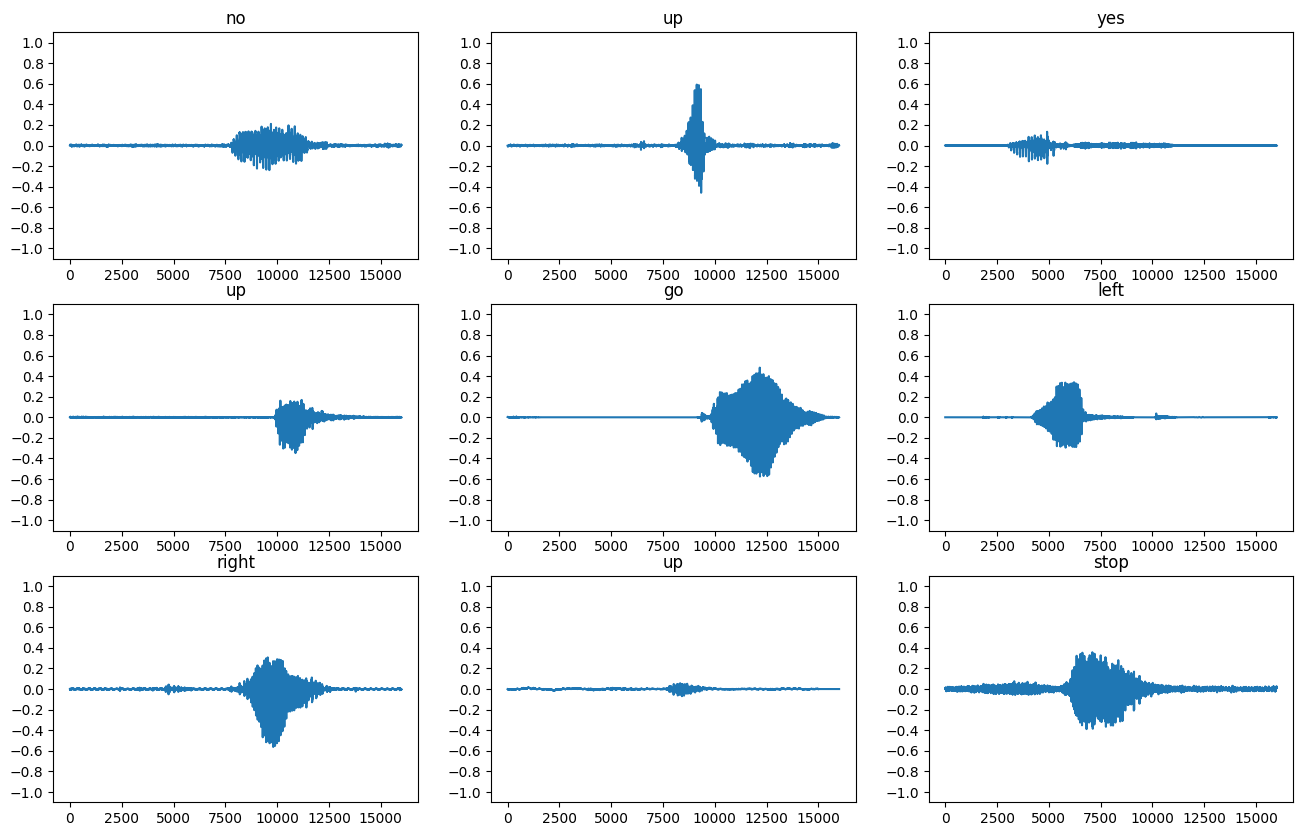

In [55]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
  plt.subplot(rows, cols, i+1)
  audio_signal = example_audio[i]
  plt.plot(audio_signal)
  #plots the audio samples for the first 9 out of the total 64 
  plt.title(label_names[example_labels[i]])
  plt.yticks(np.arange(-1.2, 1.2, 0.2))
  #plt.ylim([0, 65535])
  plt.ylim([-1.1, 1.1])



## Convert waveforms to spectrograms

The waveforms in the dataset are represented in the time domain. Next, you'll transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

#(2 dimensions - each row contains FT magnitude for a time window , rows indicate time windows)

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.

In [124]:
#  for STFT

def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  #entire signal is split into frames of "frame_length" (size of time window)
  #frame_step is the number of samples to shift the window by while taking FT
  """
  Longer windows provide better frequency resolution (ability to distinguish between 
  closely spaced frequencies) but poorer time resolution 
  (less precise identification of when frequency changes occur). 
  This is useful for analyzing steady-state sounds.

  Shorter windows provide better time resolution (ability to capture rapid changes 
  in the signal) but poorer frequency resolution (difficulty in distinguishing closely 
  spaced frequencies). This is useful for analyzing transient sounds like speech or 
  percussive instruments.


  """

  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
# #for MFCC


# def get_spectrogram(waveform):
#     spectrogram = tf.signal.stft(waveform, frame_length=256, frame_step=128, pad_end=True)  #matrix dim(125,129)  (#frames (16000/128) , frame_length//2 + 1)
#     spectrogram = tf.abs(spectrogram)
    
#     # 2. Mel filterbank
#     #num_mel_bins = 40
#     num_mel_bins = 20  #based on zephyr mfccconfig.yaml
#     num_mfccs = 13
#     num_spectrogram_bins=129  #made equal to stft matrix 2nd dim for dot-product
#     lower_freq, upper_freq= 120, 7600

#     #matrix dim(120,40)
#     linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
#         num_mel_bins,
#         num_spectrogram_bins,
#         #spectrogram.shape[-1],
#         16000,
#         lower_freq,
#         upper_freq
#     )
#     mel_spectrogram = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
#     mel_spectrogram.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

#     # 3. Log-mel spectrogram
#     log_mel_spectrogram = tf.math.log(mel_spectrogram + 1e-6)

#     spectrogram = tf.signal.mfccs_from_log_mel_spectrograms(log_mel_spectrogram)[..., :num_mfccs]
    
    
#     return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

In [58]:
# spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
# spectrogram = tf.abs(spectrogram)
# spectrogram.shape[-1]

In [125]:
for i in range(3):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback \n')
  #display.display(display.Audio(waveform, rate=16000))

Label: no
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback 

Label: up
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback 

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback 



Now, define a function for displaying a spectrogram:

In [139]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

def plot_spectrogram_2(spec, title):
    plt.figure(figsize=(8, 4))
    plt.imshow(spec.T, 
              aspect='auto', 
              origin='lower',
              extent=[0, spec.shape[0], 0, spec.shape[1]])  

    plt.colorbar(label="Magnitude")
    plt.xlabel("Time Frames")
    plt.ylabel("Frequency Bins")
    plt.title("Spectrogram")
    plt.show()
def plot_spectrogram_3(S_db, title):
    plt.figure(figsize=(10, 6))
    plt.imshow(
        S_db,
        cmap='viridis',
        interpolation="nearest"
    )
    plt.colorbar(label="Magnitude (dB)")
    plt.xlabel("Time Frames")
    plt.ylabel("Frequency Bins")
    plt.title("Spectrogram")
    plt.show()

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

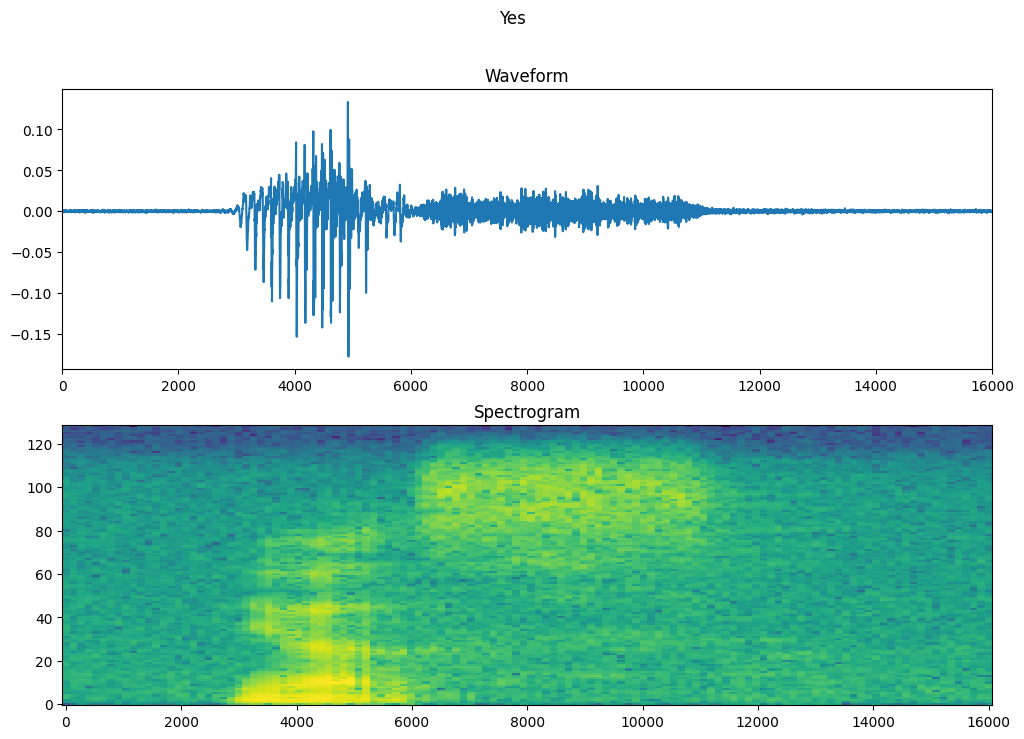

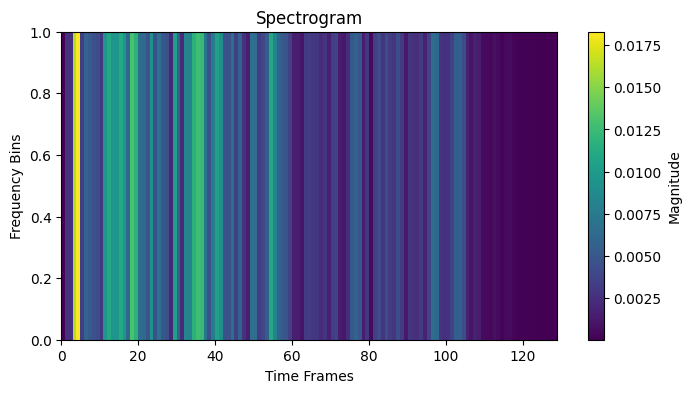

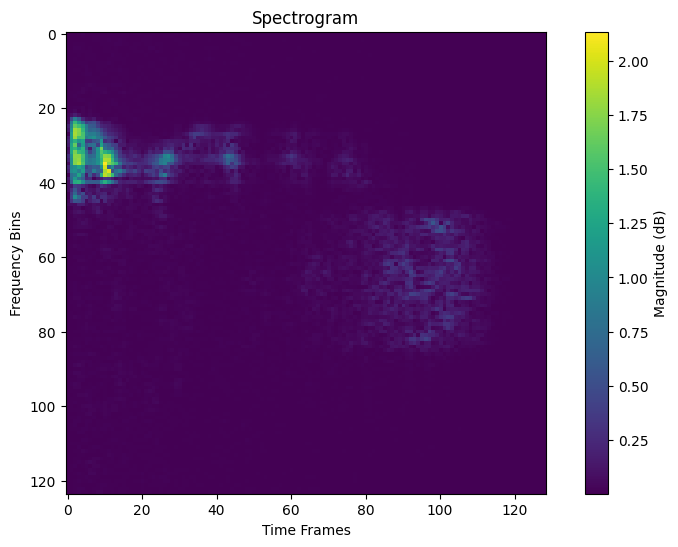

In [140]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()
plot_spectrogram_2(spectrogram[0].numpy(), label.title())
plot_spectrogram_3(spectrogram.numpy(), label.title())

Now, create spectrogram datasets from the audio datasets:

In [62]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [63]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Examine the spectrograms for different examples of the dataset:

In [64]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

C:\Users\laksh\AppData\Local\Temp\ipykernel_7892\3600643975.py:8: RuntimeWarning: invalid value encountered in log
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)


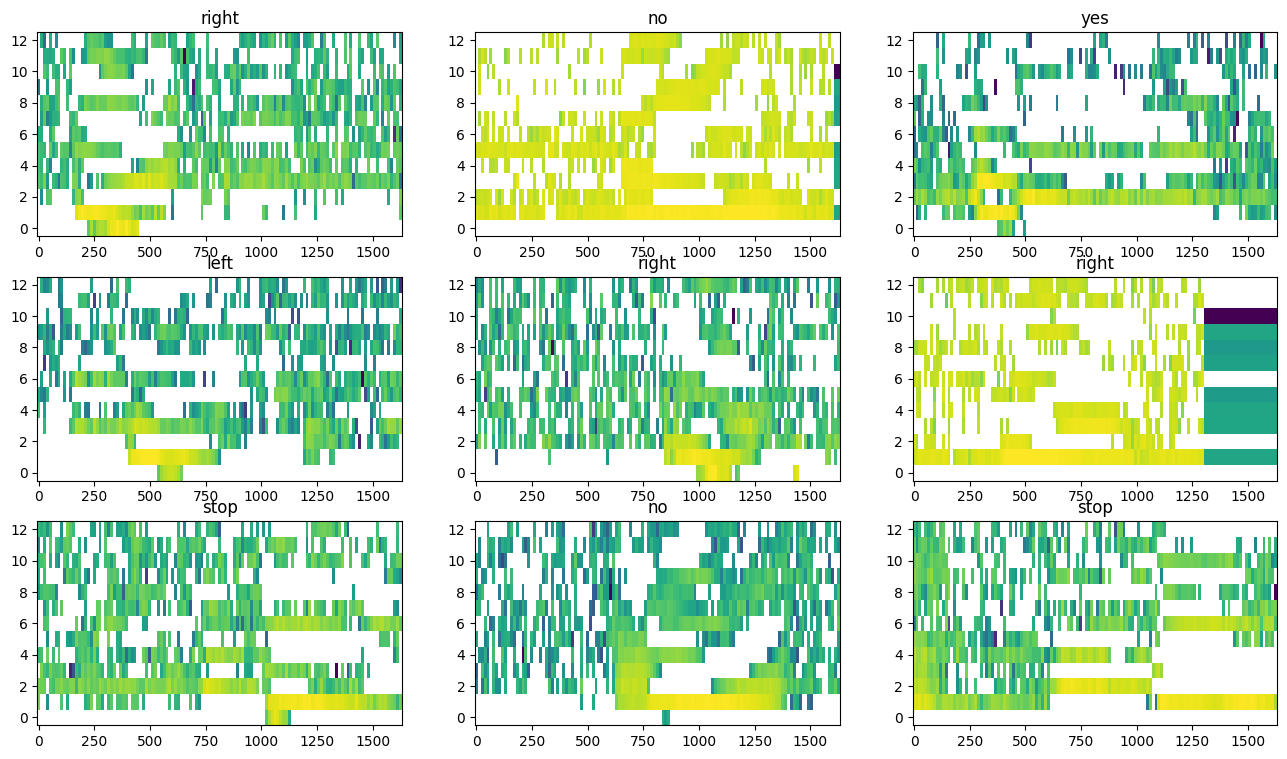

In [65]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [66]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, you'll use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images.

Your `tf.keras.Sequential` model will use the following Keras preprocessing layers:

- `tf.keras.layers.Resizing`: to downsample the input to enable the model to train faster.
- `tf.keras.layers.Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

In [67]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


#model for mfccs as input  (1D CNN)
# model = models.Sequential([
#     layers.Conv1D(8, 3, activation='relu', input_shape=(125, 13)),
#     layers.MaxPooling1D(2),
#     layers.Conv1D(16, 3, activation='relu'),
#     layers.MaxPooling1D(2),
#     #layers.Dropout(0.3), # (adding dropout caused accuracy to decrease)
#     layers.Flatten(),
#     layers.Dense(32, activation='relu'),
#     layers.Dense(num_labels, activation='softmax')
# ])

#pruning
#model = tfmot.sparsity.keras.prune_low_magnitude(base_model)

#previous models:

#modeel for mfcc input (but more parameters)
# model = models.Sequential([
#     layers.Conv1D(32, 3, activation='relu', input_shape=(125, 13)),
#     layers.MaxPooling1D(2),
#     layers.Conv1D(64, 3, activation='relu'),
#     layers.MaxPooling1D(2),
#     layers.Dropout(0.3),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(num_labels, activation='softmax')
# ])


# ##for mfcc (GRU)
# model = models.Sequential([
#     layers.GRU(64, return_sequences=False, input_shape=(125, 13)),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(num_labels, activation='softmax')
# ])

#this model was for stft spectrograms as input
# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     # Downsample the input.
#     layers.Resizing(32, 32),
#     # Normalize.
#     norm_layer,
#     layers.Conv2D(8, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(16, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     # layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(32, activation='relu'),
#     # layers.Dropout(0.5),
#     layers.Dense(num_labels, activation='softmax'),
# ])
# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     # Downsample the input.
#     layers.Resizing(32, 32),
#     # Normalize.
#     norm_layer,
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_labels, activation='softmax'),
# ])

#for LSTM
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(125, 13)),
    tf.keras.layers.LSTM(
        units=32,
        # unroll=True
    ),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    tf.keras.layers.Dense(num_labels, activation='softmax'),
])

model.summary()

Input shape: (125, 13)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,208 (28.16 KB)

 Trainable params: 7,208 (28.16 KB)

 Non-trainable params: 0 (0.00 B)

In [68]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))


# model for mfccs as input  (1D CNN)
model = models.Sequential([
    layers.Conv1D(8, 3, activation='relu', input_shape=(125, 13)),
    layers.MaxPooling1D(2),
    layers.Conv1D(16, 3, activation='relu'),
    layers.MaxPooling1D(2),
    #layers.Dropout(0.3), # (adding dropout caused accuracy to decrease)
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dense(num_labels, activation='softmax')
])

#pruning
#model = tfmot.sparsity.keras.prune_low_magnitude(base_model)

#previous models:

#modeel for mfcc input (but more parameters)
# model = models.Sequential([
#     layers.Conv1D(32, 3, activation='relu', input_shape=(125, 13)),
#     layers.MaxPooling1D(2),
#     layers.Conv1D(64, 3, activation='relu'),
#     layers.MaxPooling1D(2),
#     layers.Dropout(0.3),
#     layers.Flatten(),
#     layers.Dense(64, activation='relu'),
#     layers.Dense(num_labels, activation='softmax')
# ])


# ##for mfcc (GRU)
# model = models.Sequential([
#     layers.GRU(64, return_sequences=False, input_shape=(125, 13)),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     layers.Dense(num_labels, activation='softmax')
# ])

#this model was for stft spectrograms as input
# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     # Downsample the input.
#     layers.Resizing(32, 32),
#     # Normalize.
#     norm_layer,
#     layers.Conv2D(8, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Conv2D(16, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     # layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(32, activation='relu'),
#     # layers.Dropout(0.5),
#     layers.Dense(num_labels, activation='softmax'),
# ])
# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     # Downsample the input.
#     layers.Resizing(32, 32),
#     # Normalize.
#     norm_layer,
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_labels, activation='softmax'),
# ])

# #for LSTM
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(125, 13)),
#     tf.keras.layers.LSTM(
#         units=50,
#         # unroll=True
#     ),
#     layers.Dense(64, activation='relu'),
#     layers.Dropout(0.3),
#     tf.keras.layers.Dense(num_labels, activation='softmax'),
# ])

# #for LSTM
# model = tf.keras.Sequential([
#     tf.keras.layers.Input(shape=(125, 13)),
#     tf.keras.layers.LSTM(
#         units=32,
#         # unroll=True
#     ),
#     layers.Dense(32, activation='relu'),
#     layers.Dropout(0.3),
#     tf.keras.layers.Dense(num_labels, activation='softmax'),
# ])

model.summary()

Input shape: (125, 13)


c:\Users\laksh\zephyrproject\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 123, 8)         │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 61, 8)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 59, 16)         │           400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 29, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 464)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,864 (61.97 KB)

 Trainable params: 15,864 (61.97 KB)

 Non-trainable params: 0 (0.00 B)

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [69]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Train the model over 10 epochs for demonstration purposes:

In [70]:
EPOCHS = 15
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/15


c:\Users\laksh\zephyrproject\.venv\Lib\site-packages\keras\src\backend\tensorflow\nn.py:717: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


100/100 ━━━━━━━━━━━━━━━━━━━━ 15s 127ms/step - accuracy: 0.2092 - loss: 2.0207 - val_accuracy: 0.3542 - val_loss: 1.7213
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4716 - loss: 1.4361 - val_accuracy: 0.5911 - val_loss: 1.1710
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6122 - loss: 1.0716 - val_accuracy: 0.6641 - val_loss: 0.9616
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6825 - loss: 0.8900 - val_accuracy: 0.6823 - val_loss: 0.8799
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7334 - loss: 0.7703 - val_accuracy: 0.7318 - val_loss: 0.8039
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7647 - loss: 0.6853 - val_accuracy: 0.7526 - val_loss: 0.7395
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7859 - loss: 0.6166 - val_accuracy: 0.7747 - val_loss: 0.7079
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7997 - loss: 0.5756 - val_accuracy: 0.7539 - 

Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

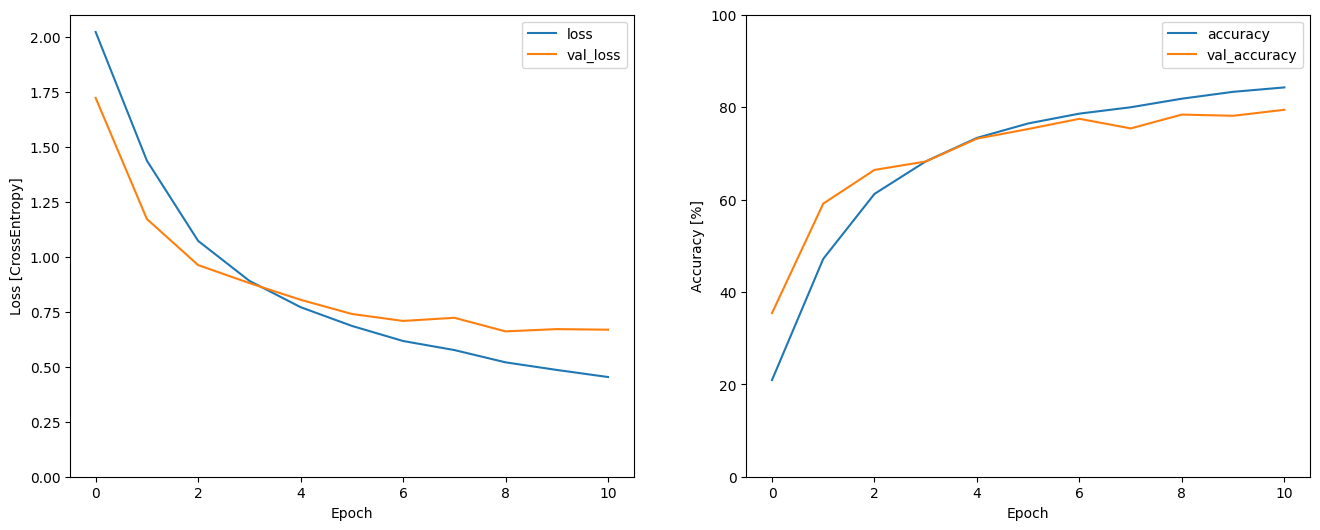

In [71]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [72]:
model.evaluate(test_spectrogram_ds, return_dict=True)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7849 - loss: 0.6164


{'accuracy': 0.7848557829856873, 'loss': 0.6163512468338013}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


In [73]:
y_pred = model.predict(test_spectrogram_ds)
print(y_pred.shape)

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step 
(832, 8)


In [74]:
y_pred = tf.argmax(y_pred, axis=1)
print(y_pred.shape)
print(y_pred[0])

(832,)
tf.Tensor(6, shape=(), dtype=int64)


In [75]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)
print(y_true.shape)

(832,)


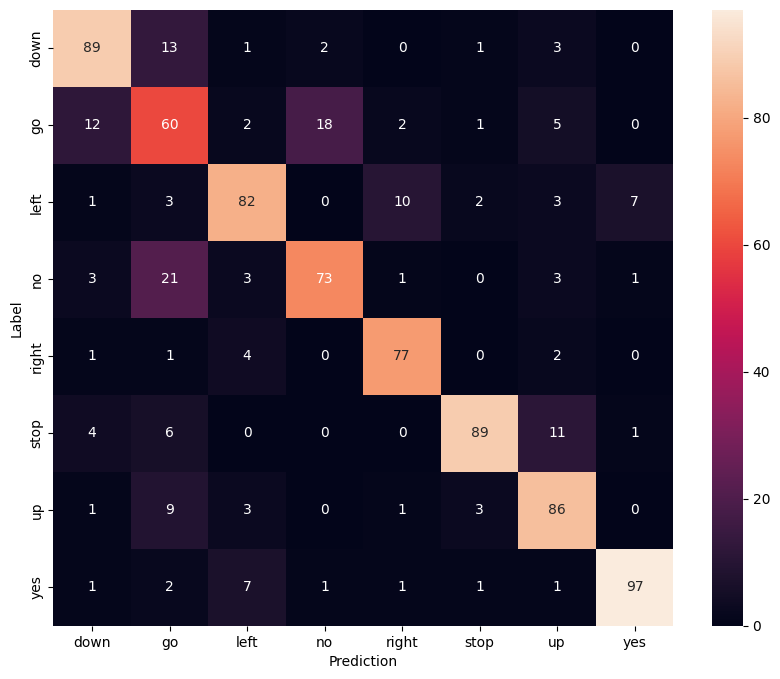

In [76]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run inference on an audio file

Finally, verify the model's prediction output using an input audio file of someone saying "no". How well does your model perform?

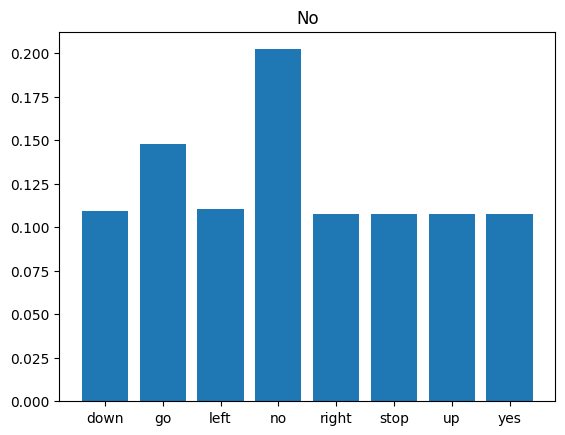

In [77]:
x = data_dir/'no/cc554de3_nohash_0.wav'
#x = data_dir/'yes/fe5c4a7a_nohash_0.wav'

x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x

# print(x)
# x = tf.multiply(x, 32767.5)
# print(x)

x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
#x_labels = ['no', 'yes', 'down', 'go', 'left', 'up', 'right', 'stop']
x_labels = ['down', 'go', 'left', 'no', 'right', 'stop', 'up', 'yes']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('No')
plt.show()

#display.display(display.Audio(waveform, rate=16000))

As the output suggests, your model should have recognized the audio command as "no".

## Export the model with preprocessing

The model's not very easy to use if you have to apply those preprocessing steps before passing data to the model for inference. So build an end-to-end version:

In [78]:
class ExportModel(tf.Module):
  def __init__(self, model):
    self.model = model

    # Accept either a string-filename or a batch of waveforms.
    # YOu could add additional signatures for a single wave, or a ragged-batch. 
    self.__call__.get_concrete_function(
        x=tf.TensorSpec(shape=(), dtype=tf.string))
    self.__call__.get_concrete_function(
       x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))


  @tf.function
  def __call__(self, x):
    # If they pass a string, load the file and decode it. 
    if x.dtype == tf.string:
      x = tf.io.read_file(x)
      x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
      x = tf.squeeze(x, axis=-1)
      x = x[tf.newaxis, :]
    
    x = get_spectrogram(x)  
    result = self.model(x, training=False)
    
    class_ids = tf.argmax(result, axis=-1)
    class_names = tf.gather(label_names, class_ids)
    return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

Test run the "export" model:

In [79]:
export = ExportModel(model)
export(tf.constant(str(data_dir/'no/01bb6a2a_nohash_0.wav')))

{'predictions': <tf.Tensor: shape=(1, 8), dtype=float32, numpy=
 array([[1.24628069e-02, 8.62833500e-01, 7.06791587e-04, 1.22830346e-01,
         2.01817194e-04, 1.08487075e-06, 8.63290275e-04, 1.00330493e-04]],
       dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'go'], dtype=object)>}

Save and reload the model, the reloaded model gives identical output:

In [80]:
#tf.saved_model.save(export, "saved")
#imported = tf.saved_model.load("saved")
#imported(waveform[tf.newaxis, :])

#modified by lkp
model.save("saved_model.keras")   # instead of tf.saved_model.save



In [81]:
#creating representative dataset for quantization

AUDIO_DIR = r"C:\Users\laksh\Downloads\IITB-Acads\EE\BTP-1\mini_speech_commands\stop"
INPUT_SHAPE = (16000,)  # Adjust to your model's input shape



def representative_dataset():
    audio_files = [os.path.join(AUDIO_DIR, f)
                   for f in os.listdir(AUDIO_DIR) if f.endswith(".wav")]
    for file in audio_files[:100]:  # Use 100-300 samples for best results
        audio, sr = sf.read(file)
        if len(audio) < INPUT_SHAPE[0]:
            # Pad if needed
            audio = np.pad(audio, (0, INPUT_SHAPE[0] - len(audio)), 'constant')
        else:
            audio = audio[:INPUT_SHAPE[0]]
        audio = np.expand_dims(audio, 0) 
        audio = tf.cast(audio, tf.float32)
        audio = get_spectrogram(audio)
        yield [audio]

In [82]:
#loading a saved model 
#model = tf.keras.models.load_model("saved_model.keras")

#convert to tflite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)

#to make the model smaller (without optimisation the org .cc file was ~4MB)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_dataset   
# converter.target_spec.supported_types = [tf.int8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8, tf.lite.OpsSet.SELECT_TF_OPS]
# Set the input and output tensors to uint8 (APIs added in r2.3)

converter._experimental_lower_tensor_list_ops = False
converter.inference_input_type = tf.int8
converter.inference_output_type = tf.int8

tflite_model = converter.convert()

# Save to file
with open("model.tflite", "wb") as f:
    f.write(tflite_model)



INFO:tensorflow:Assets written to: C:\Users\laksh\AppData\Local\Temp\tmpnpp7r184\assets


INFO:tensorflow:Assets written to: C:\Users\laksh\AppData\Local\Temp\tmpnpp7r184\assets


Saved artifact at 'C:\Users\laksh\AppData\Local\Temp\tmpnpp7r184'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 125, 13), dtype=tf.float32, name='keras_tensor_15')
Output Type:
  TensorSpec(shape=(None, 8), dtype=tf.float32, name=None)
Captures:
  1810315909008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1810315703888: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1810316122960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1810316128720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1810316127376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1810316131408: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1810316128912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1810316122576: TensorSpec(shape=(), dtype=tf.resource, name=None)


c:\Users\laksh\zephyrproject\.venv\Lib\site-packages\tensorflow\lite\python\convert.py:863: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
""" 
Note:
After generating .tflite file, we need to convert it to .cc file 
using the following command in the msys2 terminal:
xxd -i model.tflite > model.cc

other way to do it directly using python script as below:
"""

import sys

def convert_to_c_array(tflite_model, output_file):
    with open(tflite_model, "rb") as f:
        data = f.read()

    with open(output_file, "w") as f:
        f.write("#include \"model_data_small.hpp\"\n\nalignas(16) const unsigned char model_data_small[] = {")
        for i, b in enumerate(data):
            if i % 12 == 0:
                f.write("\n ")
            f.write(f"0x{b:02x}, ")
        f.write("\n};\n")
        f.write(f"const int model_data_small_len = {len(data)};\n")

# Usage
convert_to_c_array("model.tflite", "model_data_small.cpp")

In [84]:
#to know which ops should be included in the micro_mutable_op_resolver
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

for op_details in interpreter._get_ops_details():
    print(op_details['op_name'])


input_details = interpreter.get_input_details()  # List of tensors, pick [0] for the main input

# Extract scale and zero_point
scale = input_details[0]['quantization'][0]
zero_point = input_details[0]['quantization'][1]

print("Input scale:", scale)
print("Input zero_point:", zero_point)

EXPAND_DIMS
CONV_2D
RESHAPE
EXPAND_DIMS
MAX_POOL_2D
RESHAPE
EXPAND_DIMS
CONV_2D
RESHAPE
EXPAND_DIMS
MAX_POOL_2D
RESHAPE
SHAPE
STRIDED_SLICE
PACK
RESHAPE
FULLY_CONNECTED
FULLY_CONNECTED
SOFTMAX
DELEGATE
DELEGATE
DELEGATE
DELEGATE
DELEGATE
Input scale: 0.4076825678348541
Input zero_point: 86


c:\Users\laksh\zephyrproject\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [ ]:
def get_example():
    file=r"C:\Users\laksh\Downloads\IITB-Acads\EE\BTP-1\mini_speech_commands\no\fa446c16_nohash_0.wav"
    audio, sr = sf.read(file)
    if len(audio) < INPUT_SHAPE[0]:
        # Pad if needed
        audio = np.pad(audio, (0, INPUT_SHAPE[0] - len(audio)), 'constant')
    else:
        audio = audio[:INPUT_SHAPE[0]]
    for i in range(len(audio)):
        audio[i] = round(audio[i], 7)
    #audio = tf.cast(audio, tf.float32)
    result = "arr = [" + ", ".join(map(str, audio)) + "]"
    print(result)
get_example()

arr = [3.05e-05, 6.1e-05, 6.1e-05, 6.1e-05, 3.05e-05, 6.1e-05, 6.1e-05, 6.1e-05, 6.1e-05, 6.1e-05, 3.05e-05, 6.1e-05, 6.1e-05, 6.1e-05, 9.16e-05, 9.16e-05, 0.0001221, 0.0001221, 0.0001526, 0.0001831, 0.0001831, 0.0001831, 0.0001831, 0.0002136, 0.0002136, 0.0001831, 0.0002136, 0.0002136, 0.0001831, 0.0001526, 0.0001831, 0.0001831, 0.0001526, 0.0001526, 0.0001831, 0.0002136, 0.0002136, 0.0003052, 0.0003357, 0.0003967, 0.0004578, 0.0005493, 0.0007019, 0.0007629, 0.000946, 0.0011292, 0.0012817, 0.0014038, 0.0014954, 0.0016479, 0.001709, 0.0018921, 0.0021057, 0.0021057, 0.0021362, 0.0021362, 0.0021362, 0.0021362, 0.0020752, 0.0020447, 0.0020142, 0.0020142, 0.0019531, 0.0018921, 0.0019531, 0.0019226, 0.0019226, 0.0019531, 0.0019836, 0.0020142, 0.0020752, 0.0021667, 0.0022583, 0.0023499, 0.0024719, 0.002594, 0.0027161, 0.0028076, 0.0028992, 0.0029602, 0.0030518, 0.0030212, 0.0030212, 0.0030212, 0.0029907, 0.0029602, 0.0028992, 0.0028381, 0.0027771, 0.0027161, 0.0026245, 0.002533, 0.0024719, 0

## Next steps

This tutorial demonstrated how to carry out simple audio classification/automatic speech recognition using a convolutional neural network with TensorFlow and Python. To learn more, consider the following resources:

- The [Sound classification with YAMNet](https://www.tensorflow.org/hub/tutorials/yamnet) tutorial shows how to use transfer learning for audio classification.
- The notebooks from [Kaggle's TensorFlow speech recognition challenge](https://www.kaggle.com/c/tensorflow-speech-recognition-challenge/overview).
- The 
[TensorFlow.js - Audio recognition using transfer learning codelab](https://codelabs.developers.google.com/codelabs/tensorflowjs-audio-codelab/index.html#0) teaches how to build your own interactive web app for audio classification.
- [A tutorial on deep learning for music information retrieval](https://arxiv.org/abs/1709.04396) (Choi et al., 2017) on arXiv.
- TensorFlow also has additional support for [audio data preparation and augmentation](https://www.tensorflow.org/io/tutorials/audio) to help with your own audio-based projects.
- Consider using the [librosa](https://librosa.org/) library for music and audio analysis.